# Zaawansowane Metody Inteligencji Obliczeniowej
## Lab 8: Q-Learning z aproksymacją
### Prowadzący: Michał Kempka, Marek Wydmuch

## Wprowadzenie

Celem tego ćwiczenia jest implementacja algorytmu Q-Learning z aproksymacją dla środowiska `CartPole` ze znanej Wam już bibliteki ~~OpenAI Gym~~ Gymnasium (https://gymnasium.farama.org/), która jest kontynuacją biblioteki Gym.


Zapoznaj się z opisem środowiska (https://gymnasium.farama.org/environments/classic_control/cart_pole/) następnie zapoznaj się z kodem poniżej. Pokazuje on przykład użycia omawianego środowiska.

In [1]:
# Zainstaluj bibliotekę Gymnasium i PyTorch
!pip install gymnasium==0.28 torch matplotlib numpy

'pip' is not recognized as an internal or external command,
operable program or batch file.


### Środowisko `CartPole`

Poniższy kod demonstruje działanie środowiska `CartPole`

In [4]:
# Zobacz jak działa środowisko na przykładzie 100 kroków
import gymnasium as gym

# Inicjalizacja środowiska
env = gym.make("CartPole-v1")
observation, _ = env.reset()

for _ in range(100):
    # Pokaż obraz z środowiska
    #env.render()

    # Wybierz losową akcję z przestrzeni akcji
    action = env.action_space.sample()

    # Wykonaj akcję i otrzymaj informację o kolejnym stanie, nagrodzie 
    # i czy środowisko zostało zakończone.
    # Zobacz https://gymnasium.farama.org/api/env/#gymnasium.Env.step 
    # by sprawdzić opis wszystkich zwracanych wartości.
    observation, reward, term, trunc, _ = env.step(action)
    done = term or trunc
    
    if done:
        observation, _ = env.reset()
env.close()

In [5]:
# Zobacz jakim typem są obserwacje (reprezentacja stanu) oraz jaka jest przestrzeń akcji:
print("Przestrzeń stanów:", env.observation_space)
print("Ostatnia obserwacja:", observation)
print("Przestrzeń akcji:", env.action_space)

Przestrzeń stanów: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Ostatnia obserwacja: [ 0.03387388  0.92724574 -0.00698775 -1.353956  ]
Przestrzeń akcji: Discrete(2)


### Regresja w PyTorch

Poniższy kod demosntruje jak stworzyć prosty model za pomocą bilibteki PyTorch dla problemu regresji.

In [6]:
import torch
import torch.nn.functional as F

class MyModel(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(MyModel, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)  # Warstwa wejściowa
        self.predict = torch.nn.Linear(n_hidden, n_output)  # Warstwa wyjściowa

    # W momencie wykonania tych operacji zostanie stworzony graf obliczeniowy, który zostanie wykorzystany do propagacji wstecznej
    def forward(self, x):
        x = F.relu(self.hidden(x))  # Wejście + funkcja aktywacji
        x = self.predict(x)         # Liniowe wyjście
        return x

h = MyModel(n_feature=1, n_hidden=50, n_output=1)

# Poza samym modelem, w celu jego uczenia potrzebujemy optymalizatora (w tym wypadku algorytmu SGD)
optimizer = torch.optim.SGD(h.parameters(), lr=0.2)

# Oraz naszej funkcji straty, w tym wypadku uyjmy błędu kwadratowego
loss_func = torch.nn.MSELoss()

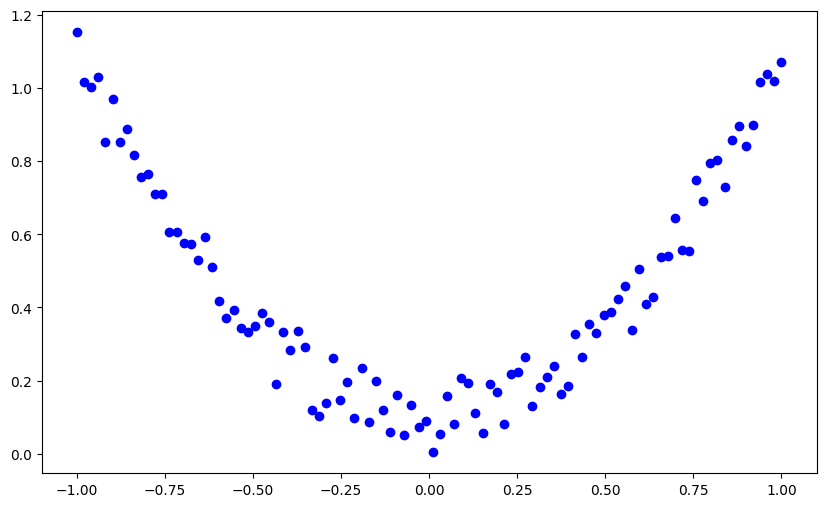

In [7]:
# Stwórzmy przykładowe, jednowmiarowe dane i wyświetlmy je
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)
y = x.pow(2) + 0.2 * torch.rand(x.size())

plt.figure(figsize=(10,6))
plt.scatter(x.data.numpy(), y.data.numpy(), color="blue")
plt.show()

In [8]:
# Wytrenujmy nasz model wykonując 1000 iteracji po całym zbiorze danych
for t in range(1000):
    # Dokonaj predykcji na podstawie x
    prediction = h(x)
    
    # Wyliczmy błąd
    loss = loss_func(prediction, y)
    
    # Wyzerujmy gradienty
    optimizer.zero_grad()
    
    # Wylicz gradienty dla każdej operacji z użyciem propagacji wstecznej
    loss.backward()

    # Zaktualizuj wagi
    optimizer.step()

In [9]:
# Wykonajmy ostateczną predykcję, nie potrzebujemy już gradientów ani grafu obliczeniowego
with torch.no_grad():
    prediction = h(x)

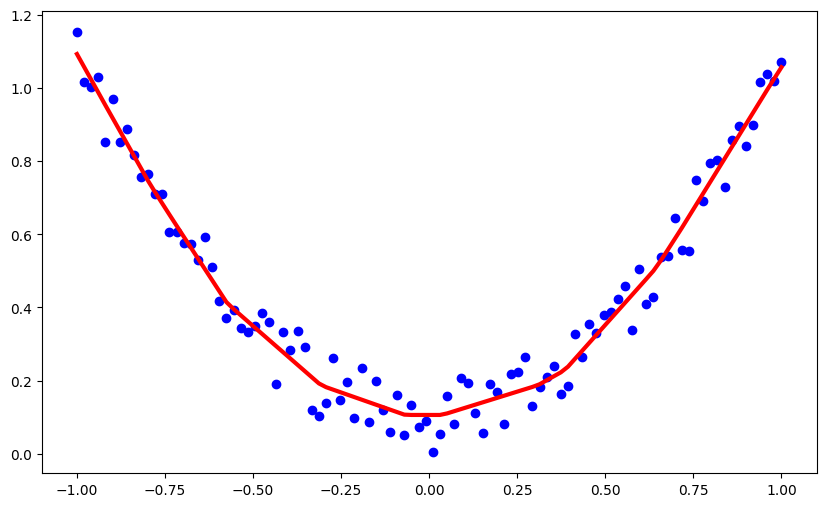

In [10]:
# Wyświetlmy wyniki
plt.figure(figsize=(10,6))
plt.scatter(x.data.numpy(), y.data.numpy(), color="blue")
plt.plot(x.data.numpy(), prediction.data.numpy(), color="red", lw=3)
plt.show()

## Ćwiczenie: zaimplementuj algorytm Q-Learning z aproksymacją dla środowiska `CartPole`

In [11]:
# Dla ładnych pasków postępu
!pip install tqdm

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [12]:
# Klasa modelu dla estymacji wartości akcji dla problemu Cart Pole
class MyModel(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(MyModel, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, 64)  # Warstwa wejściowa/pierwsza ukryta
        self.hidden2 = torch.nn.Linear(64, 32)         # Druga warstwa ukryta
        self.predict = torch.nn.Linear(32, n_output)   # Warstwa wyjściowa

    # W momencie wykonania tych operacji zostanie stworzony graf obliczeniowy, który zostanie wykorzystany do propagacji wstecznej
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.predict(x)
        return x

In [14]:
from tqdm import trange
from random import random


# Funkcja do predykcji z modelu h dla stanu S bez grafu obliczeniowego/gradientów
def predict(h, S):
  with torch.no_grad():  # Wyłączenie liczenia gradientów dla bloku poniżej
    return h(torch.Tensor(S))  # Stan musi być typu torch.tensor, dlatego dodajemy rzutowanie


# Nasza implementacja Q-Learningu z aproksymacją
def qlearning(env, h, optim, episodes, gamma=0.9, epsilon=0.2, eps_decay=0.99):

  rewards = []  # Chcemy przechowywać historię sumarycznych nagród z epizodów
  loss_func = torch.nn.MSELoss()  # Nasza funkcja straty

  for episode in trange(episodes):  # Pętla po epizodach
    S, _ = env.reset()  # Na start resetujemy nasze środowisko
    done = False  # Zmienna oznaczająca stan terminaly
    total_R = 0  # Zmienna to przechowywania sumarycznej nagrody

    while not done:  # Do póki nie zakończymy epizodu

      # Wybór kolejnej akcji - implementacja polityki epsilon-greedy
      if random() < epsilon:
        A = env.action_space.sample()
      else:
        Q = predict(h, S)
        A = torch.argmax(Q).item()

      # Wykonanie akcji i postprecessing zwróconych zmiennych
      S_next, R, term, trunc, _ = env.step(A)
      done = term or trunc
      total_R += R

      # Aktualizacja estymatora wartości stanów

      # Zerujemy gradien dla optymalizowanych wag
      optim.zero_grad()

      # Wykonajmy predykcję funkcji wartości dla aktualnego stanu i akcji
      pred = h(torch.Tensor(S))[A]

      if done:
        # Jeśli stan terminalny to naszym celem jest estymacja nagrody z ostatniego kroku
        target = R
      else:  
        # W innym wypadku naszym celem jest estymacja nagrody z ostatniego kroku 
        # + zdyskontowana przyszłośc po zachłannej polityce.
        target = R + gamma * torch.max(predict(h, S_next)).item()

      # Liczmy wartość naszej funkcji straty, target jest jedynie floatem, więc musmy go zrzutowąć na torch.tensor
      loss = loss_func(pred, torch.Tensor([target]))

      # Wyliczamy gradienty
      loss.backward()
      
      # Dokonujemy aktualizacji wag z użyciem algorytmu optymalizującego
      optim.step()

      # Na koniec przypisujemy następny stan do aktualnego
      S = S_next

    # Po zakonczonym epizodzie obniżamy epsilon i zapisujemy uzyskaną sumaryczną nagrodę
    epsilon = max(epsilon * eps_decay, 0.01)
    rewards.append(total_R)

  return rewards

In [15]:
env = gym.make("CartPole-v1")  # Inicjalizacja nowego środowiska
h = MyModel(env.observation_space.shape[0], env.action_space.n)  # Inicjalizacja modelu dla estymatora n_features=4 i n_output=2
optimizer = torch.optim.SGD(h.parameters(), lr=0.001)  # Inicjalizacja optymalizatora
rewards = []  # Inicjalizacja listy wszytkich nagród

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [00:31<00:00, 31.45it/s]


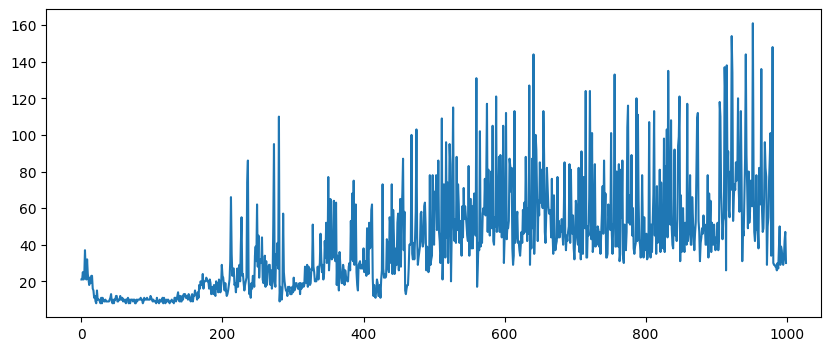

In [16]:
rewards.extend(qlearning(env, h, optimizer, 1000))  # Wykonaj 1000 epizodów naszego algorytmu qlearning

# Narysuj historię wszystkich nagród od momentu inicjalizacji modelu
plt.figure(figsize=(10, 4))
plt.plot(rewards)
plt.show()